# 6 Inference on CPU

### 1. Import dependencies

In [193]:
%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm.notebook import trange, tqdm
from PIL import Image
import tarfile
import os.path
import sagemaker
import json
import shutil

In [195]:
import datetime
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-15 20:12:37.794331


In [196]:
torch.__version__

'1.4.0'

### 2. Download model parameters

In [197]:
# handler to sagemaker session object
session = sagemaker.Session()

# pull source_data_2.tar.gz from S3
prefix = 'road-signs-classifier'
bucket = 'sagemaker-us-east-1-731572931236'
session.download_data(path='downloads', bucket=bucket, key_prefix=prefix)

In [198]:
def extract_tar_gz(filename, destination_dir):
    with tarfile.open(filename, 'r:gz') as _tar:
        _tar.extractall(destination_dir)

def make_tar_gz(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

def make_tar_gz_list(output_filename, path_list):
    with tarfile.open(output_filename, "w:gz") as tar:
        for path in path_list:
            tar.add(path, arcname=os.path.basename(path), recursive=True)
        
def make_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
def rm_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

make_dir('./test')
extract_tar_gz('./downloads/source_data_2.tar.gz', './test')
make_dir('./model')
extract_tar_gz('./downloads/model-99-177.tar.gz', './model')

### 3. Create PyTorch data generators

In [199]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

In [200]:
# define dataloader parameters
batch_size = 64
num_workers_test = 4
normalize = transforms.Normalize(mean=[0.5],
                                 std=[0.5])

data_transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        normalize
])

test_dataset = datasets.ImageFolder('./test/test/', data_transform_test)
c = torch.utils.data.DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_test)
test_dataloader =WrappedDataLoader(c, to_device)

### 4. Create and initialize the network

In [201]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [202]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [203]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x
model = BaselineNet().to(device)

In [204]:
print(model)

BaselineNet(
  (stn): Stn(
    (loc_net): Sequential(
      (0): Conv2d(1, 50, kernel_size=(7, 7), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ELU(alpha=1.0)
      (3): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ELU(alpha=1.0)
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=1600, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con

In [205]:
model.load_state_dict(torch.load('./model/model.pre-trained_5', map_location=torch.device(device)))

<All keys matched successfully>

In [206]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)


In [207]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)



In [208]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

### 5. Confusion matrix and top confused classes

In [28]:
%%time
n_classes = 43
def create_confusion_matrix(model, dl):
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)
    with torch.no_grad():
        for batch in dl:
            images, labels = batch
            images = images.to(device)
            preds_all_classes = model(images)
            preds =  torch.argmax(preds_all_classes, 1) # get top class
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    conf_matrix = torch.zeros(n_classes, n_classes)
    for t, p in zip(all_labels.cpu().numpy(), all_preds.cpu().numpy()):
        conf_matrix[t, p] += 1
    conf_matrix = np.asarray(conf_matrix.numpy().astype(int))
    return conf_matrix

conf_matrix = create_confusion_matrix(model, test_dataloader)
conf_matrix

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


CPU times: user 1min 12s, sys: 706 ms, total: 1min 13s
Wall time: 39.9 s


In [29]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, zero_diagonal=False):
    if zero_diagonal:
        cm = np.copy(cm)
        np.fill_diagonal(cm, 0)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 60   0   0 ...   0   0   0]
 [  0 720   0 ...   0   0   0]
 [  0   2 746 ...   0   0   0]
 ...
 [  0   0   0 ...  88   0   0]
 [  0   0   0 ...   0  60   0]
 [  0   0   0 ...   2   0  88]]


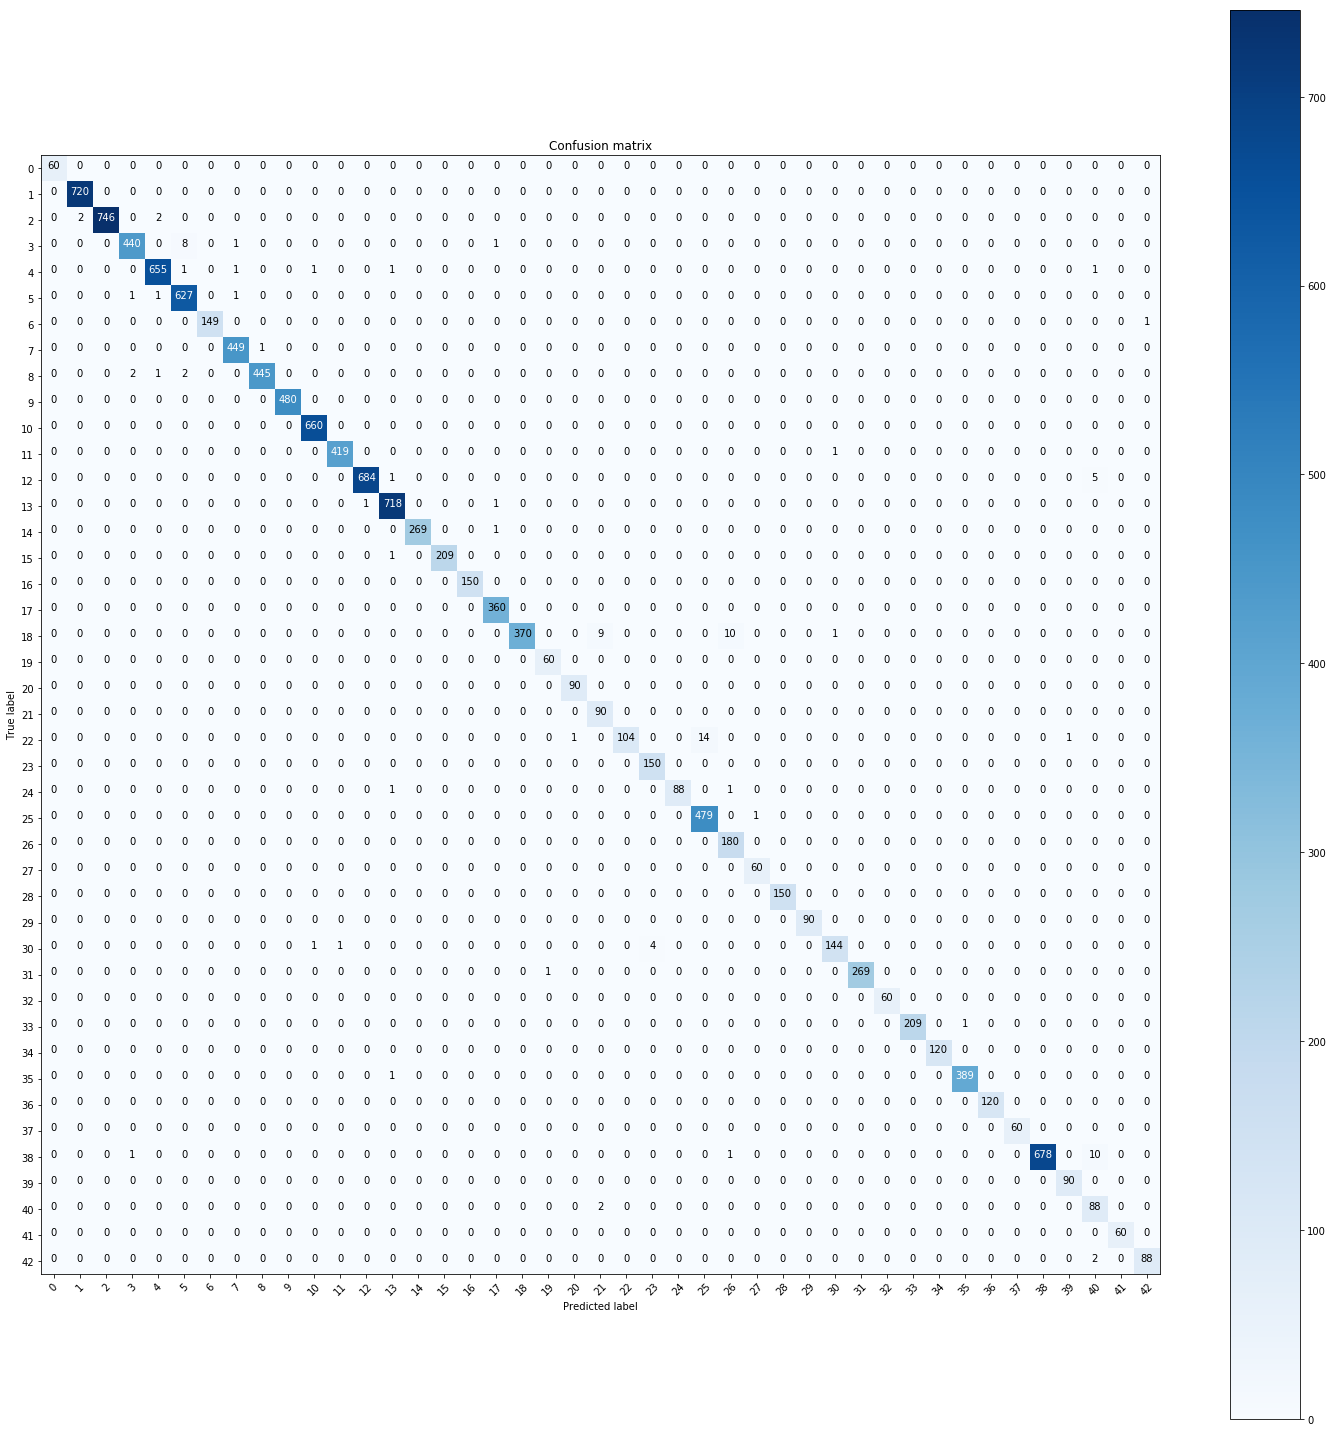

In [30]:
#np.fill_diagonal(conf_matrix, 0)
plot_confusion_matrix(conf_matrix, range(43), zero_diagonal=False)

In [31]:
def take_third(elem):
    return elem[2]

def get_top_conf(conf_matrix):
    np.fill_diagonal(conf_matrix, 0)
    min_val = 3
    classes = range(43)
    res = [(classes[i],classes[j],conf_matrix[i,j])
                    for i,j in zip(*np.where(conf_matrix>=min_val))]
    return sorted(res, key=take_third, reverse=True)

print(get_top_conf(conf_matrix))

[(22, 25, 14), (18, 26, 10), (38, 40, 10), (18, 21, 9), (3, 5, 8), (12, 40, 5), (30, 23, 4)]


In [32]:
%%time
criterion = nn.CrossEntropyLoss()
evaluate(model, criterion, test_dataloader)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Test loss: 0.029522	Test accruacy: 99.177%
CPU times: user 1min 11s, sys: 1.11 s, total: 1min 12s
Wall time: 39.2 s


### 6. Sample losers

I would like to offer users of my app sample images gruped in four categories:
- correctly classified images with confidence >= 99% - easy cases
- correctly classified images with confidence between 70% and 90% - medium cases
- correctly classified images with confidence <= 70% - difficult cases
- incorrectly classified images with highconfidence

To do that we will create new data loader returning for each test image a label and a path.
We will then use our model to calculate predicted label and confidence.

In [209]:
class GTSRB_Test_2(Dataset):
    '''
    A slightly modifed version of GTSRB_Test which returns paths to images 
    and uses integer class labels
    '''
    
    def __init__(self, images_dir='./source_data/test/GTSRB/Final_Test/Images', 
                 gt_csv_path='./source_data/test/GT-final_test.csv', transform=None):
        """
        Args:
            images_dir (string): Path to GTSRB images directory
            gt_csv_path: path to test ground truth csv file
            transform (callable, optional): Optional transform to be applied

        Attributes:
            classes (list): List of the class names.
            class_to_idx (dict): Dict with items (class_name, class_index).    
            
        """
        self.images_dir = images_dir
        self.gt_csv_path = gt_csv_path

        self.gt_data = pd.read_csv(gt_csv_path, header=0, sep=';')
        self.transform = transform
        
        classes, class_to_idx = self._find_classes()
        self.classes = classes
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.gt_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.gt_data.iloc[idx, 0])
        img = Image.open(img_path)

        classId = self.gt_data.iloc[idx, self.gt_data.columns.get_loc('ClassId')]
        if self.transform is not None:
            img = self.transform(img)
            
        return img, classId, img_path
    
    def _find_classes(self):
        """
        Finds the classes in the dataset

        Args:

        Returns:
            tuple: (classes, class_to_idx), class_to_idx is a dictionary.
        """
        classes = pd.unique(self.gt_data['ClassId'])
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

In [210]:
# Create Dataset
test_dataset = GTSRB_Test_2(
    images_dir  = './source_data/test/GTSRB/Final_Test/Images', 
    gt_csv_path = './source_data/test/GT-final_test.csv',
    transform = data_transform_test)


Calcuate predictions and max confidence values

In [211]:
%%time

n_classes = 43
def get_losers(model, dl, high_conf_threshold, low_conf_threshold):
    model.eval()
    all_preds = []
    all_labels = []
    all_image_paths = []
    all_confidence = []

    high_confidence = []
    low_confidence = []
    medium_confidence = []
    losers = []

    with torch.no_grad():
        for batch in dl:
            images, labels, image_paths = batch
            all_labels.extend(labels.cpu().numpy())
            all_image_paths.extend(image_paths) 
            
            images = images.to(device)
            preds_all_classes = F.softmax(model(images), dim=1)
            confidence, preds = torch.max(preds_all_classes, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_confidence.extend(confidence.cpu().numpy())

    for true, pred, path, conf in zip(all_labels, all_preds, all_image_paths, all_confidence):
        if pred != true:
            losers.append((true, pred, path, conf))
        else:
            if conf>=high_conf_threshold:
                high_confidence.append((true, pred, path, conf))
            elif conf<=low_conf_threshold:
                low_confidence.append((true, pred, path, conf))
            else:
                medium_confidence.append((true, pred, path, conf))
                            
    return losers, high_confidence, low_confidence, medium_confidence

# Load Dataset
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2)

losers, high_confidence, low_confidence, medium_confidence = get_losers(model, test_dataloader, 0.99, 0.7)
print('losers: {}'.format(len(losers)))
print('high_confidence: {}'.format(len(high_confidence)))
print('low_confidence: {}'.format(len(low_confidence)))
print('medium_confidence: {}'.format(len(medium_confidence)))




/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


losers: 104
high_confidence: 11861
low_confidence: 86
medium_confidence: 579
CPU times: user 1min 15s, sys: 7.11 s, total: 1min 22s
Wall time: 44.9 s


File counts for edge cases are well balanced for my use case so I will save them in S3, converting to PNG on the way. Such data can be directly used by web app backend without any additional processing. 

In [223]:
os.system("rm -rf ./samples")
make_dir('./samples')
make_dir('./samples/losers')
make_dir('./samples/low_confidence')
make_dir('./samples/medium_confidence')
make_dir('./samples/high_confidence')

i=0
for true, pred, path, conf in sorted(losers,key=lambda x: x[3], reverse=True)[:42]:
    Image.open(path).save('./samples/losers/{}.png'.format(i))
    i += 1
    
i=0
for true, pred, path, conf in sorted(low_confidence,key=lambda x: x[3], reverse=True)[:42]:
    Image.open(path).save('./samples/low_confidence/{}.png'.format(i))
    i += 1

i=0
for true, pred, path, conf in sorted(medium_confidence,key=lambda x: x[3], reverse=True)[:42]:
    Image.open(path).save('./samples/medium_confidence/{}.png'.format(i))
    i += 1
    
i=0
for true, pred, path, conf in sorted(high_confidence,key=lambda x: x[3], reverse=True)[:42]:
    Image.open(path).save('./samples/high_confidence/{}.png'.format(i))
    i += 1
        
make_tar_gz_list('samples.tar.gz', ['./samples/losers', './samples/low_confidence', './samples/medium_confidence', './samples/high_confidence'])


In [224]:
# handler to sagemaker session object
session = sagemaker.Session()
prefix = 'road-signs-classifier'

# compress and push samples to S3
samples_ulr = session.upload_data(path='samples.tar.gz', key_prefix=prefix)
samples_ulr

's3://sagemaker-us-east-1-731572931236/road-signs-classifier/samples.tar.gz'

### 7. Make predictions on sample test images¶

Web application will need to handle individual images, potentially uploaded by users so let's practice here.

In [33]:
validation_img_paths = ["./test/test/00/00243.ppm",
                        "./test/test/01/00001.ppm",
                        "./test/test/02/00034.ppm"]
validation_img_paths = ["./own_images/sign1.PNG",
                        "./own_images/sign2.PNG",
                        "./own_images/sign3.PNG",
                        "./own_images/sign4.PNG",
                        "./own_images/sign5.PNG",
                        "./own_images/sign6.PNG",
                        "./own_images/sign7.PNG",
                        "./own_images/sign8.PNG",
                        "./own_images/sign9.PNG",
                        "./own_images/sign10.PNG"]

img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_classes = [31, 18, 11, 20, 22, 13, 12, 1, 21, 25]

In [34]:
validation_batch = torch.stack([data_transform_test(img).to(device)
                                for img in img_list])

In [35]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


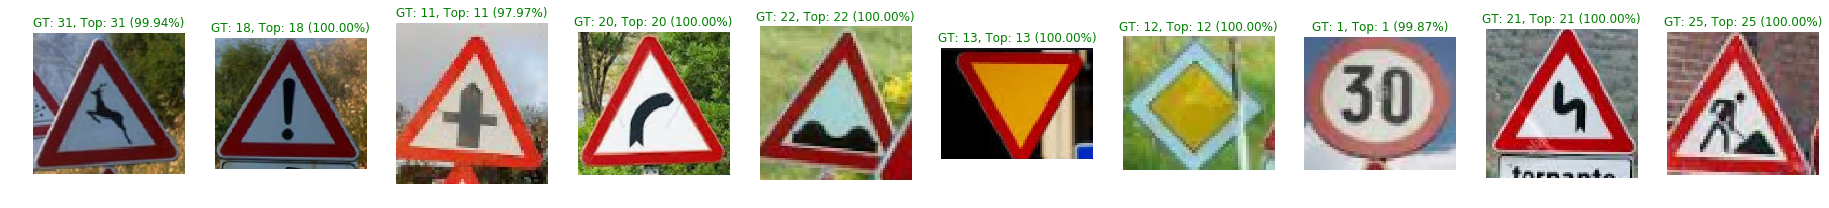

In [36]:
fig, axs = plt.subplots(1, len(img_list), figsize=(32, 32))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    maxConfidenceValue = np.amax(pred_probs[i,:])
    maxConfidenceClass = np.where(pred_probs[i,:] == maxConfidenceValue)[0][0]
    color = 'green'
    if maxConfidenceClass != validation_classes[i]:
        color = 'red'
    ax.set_title("GT: {}, Top: {} ({:.2f}%)".format(validation_classes[i], maxConfidenceClass, maxConfidenceValue*100), color=color)
    ax.imshow(img)

### 8. Visualizing STN Layer

I would also like to visualize input data and STN layer, following this [tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


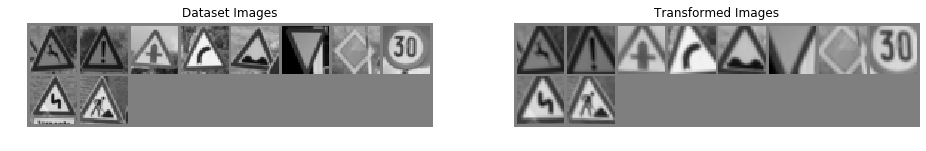

In [37]:

def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn(data):
    with torch.no_grad():
        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()
        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
data = torch.stack([data_transform_test(img).to(device)
                                for img in img_list])
visualize_stn(data)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Predicted: Yield ( 1.0 )
CPU times: user 135 ms, sys: 12 ms, total: 147 ms
Wall time: 111 ms


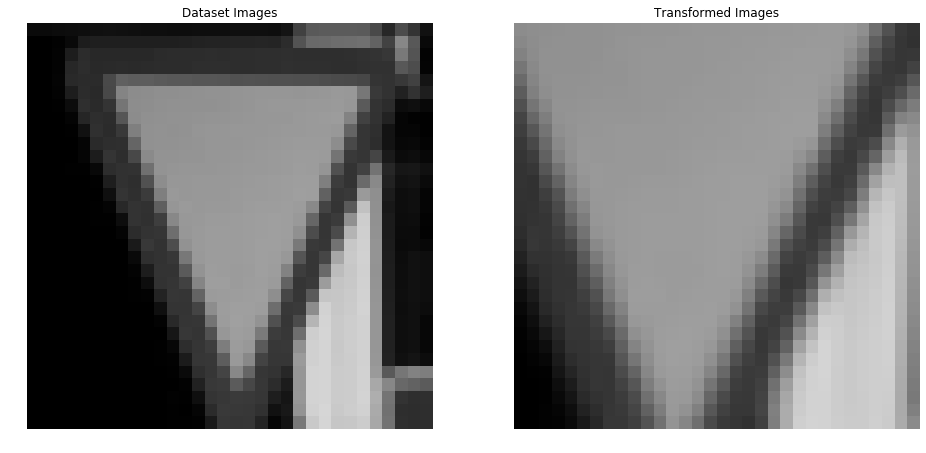

In [46]:
%%time
model.eval()
img_path = "./own_images/sign6.PNG"
img_transform=data_transform_test(Image.open(img_path)).to(device)
input = torch.stack([img_transform])

labels_path = './own_images/class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
visualize_stn(input)

In [39]:
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-15 07:15:29.128649


Cleanup

In [40]:
#os.system("rm -rf ./test")
#os.system("rm -rf ./model")
#os.system("rm -rf ./samples")